# Import, Init

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-o2w33y3j because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  0
>>> train-test inited:  
 	X_train len -->  1998 y_train len -->  1998 
 	X_test len -->  1997 y_test len -->  1997 
 	NULLS in data -->  0


In [4]:
# Adding closing price of the current day
nn_manager_cut.X_train['Price'] = nn_manager_cut.y_train
nn_manager_cut.X_test['Price'] = nn_manager_cut.y_test

In [5]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY', 'Price'],
      dtype='object')

In [6]:

## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week
nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY', 'Price'],
      dtype='object')

In [7]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


# Preparing data

#### Swapping (the trial issue)
[[to #Model-fit]](#Model-fit)

In [8]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_test = nn_manager_cut.X_train.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = nn_manager_cut.y_train.copy()
nn_manager_cut.y_train = tmp.copy()

print("X_train => ", nn_manager_cut.X_train.shape[0])
print("X_test => ", nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train =>  1997
X_test =>  1998
	train data period =>  2016-01-06 00:00:00 --> 2021-06-24 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2016-01-05 00:00:00


#### Keeping Holdout Samples Aside

In [9]:
hould_out_days = 28
hold_out_X = nn_manager_cut.X_train[-hould_out_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-hould_out_days]

hold_out_y = nn_manager_cut.y_train[-hould_out_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-hould_out_days]

print("X_train, X_test --> ", nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0])
print("Holdout period --> ", hold_out_X.index.min(), "-->", hold_out_X.index.max())

X_train, X_test -->  1969 1998
Holdout period -->  2021-05-28 00:00:00 --> 2021-06-24 00:00:00


## Normalizing

In [10]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

# ### tmp ### 
# nn_manager_cut.X_train_normalized = nn_manager_cut.X_train.values 
# nn_manager_cut.X_test_normalized = nn_manager_cut.X_test.values 

(
    nn_manager_cut.X_train_normalized[:2], 
    nn_manager_cut.X_train_transformed
)

(array([[-0.77702875, -0.77734489, -0.2460216 , -0.22976293, -0.34870458,
         -0.91497121, -0.87802167,  0.97272727,  0.01246556,  0.10278508,
         -0.7807569 ],
        [-0.7739491 , -0.77690072, -0.06409477, -0.06594149, -0.30714811,
         -0.93569728, -0.87737083,  1.33636364,  1.17202467, -0.91180095,
         -0.77750168]]),
 None)

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [11]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=1))

self.training_seq_params -->  {'seq_len': 1, 'n_features': 11}
self.X_train_shape -->  [1, 11]
self.X_test_shape -->  [1, 11]


True

In [12]:
nn_manager_cut.unroll_train_test_to_sequences(shift=0)

nn_manager_cut.X_train[0:1] # if seq=1 then slicing from 0 to 1 will be 0th element

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY,Price
Date,,,,,,,,,,,
2016-01-06,432.1,425.0,43430.0,1.337497e+06,30.189822,0.684647,102066558.0,3100.0,-1600.0,314556.0,430.8


In [13]:
# goes up by one sequence -- compare this cell result vs previous

print("X_unrolled [0] -->\n", nn_manager_cut.X_train_unrolled[0], '\t=>', nn_manager_cut.y_train_unrolled[0])
print("\nX_unrolled [1] -->\n", nn_manager_cut.X_train_unrolled[1], '\t=>', nn_manager_cut.y_train_unrolled[1])
print("\nX_unrolled [2] -->\n", nn_manager_cut.X_train_unrolled[2], '\t=>', nn_manager_cut.y_train_unrolled[2])

X_unrolled [0] -->
 [[-0.77702875 -0.77734489 -0.2460216  -0.22976293 -0.34870458 -0.91497121
  -0.87802167  0.97272727  0.01246556  0.10278508 -0.7807569 ]] 	=> [457.]

X_unrolled [1] -->
 [[-0.7739491  -0.77690072 -0.06409477 -0.06594149 -0.30714811 -0.93569728
  -0.87737083  1.33636364  1.17202467 -0.91180095 -0.77750168]] 	=> [452.9]

X_unrolled [2] -->
 [[-0.77329437 -0.77461643 -0.14563371 -0.26493516 -0.32382284 -1.22289767
  -0.87717789  2.20909091 -0.47684031 -1.84072655 -0.77801108]] 	=> [448.3]


In [14]:
# on the base of the first {seq_len} elements of the sequence we want to predict the next day price

nn_manager_cut.y_train.iloc[:6], nn_manager_cut.y_train_unrolled[:6]

(            Price
 Date             
 2016-01-06  430.8
 2016-01-07  457.0
 2016-01-08  452.9
 2016-01-09  448.3
 2016-01-10  446.2
 2016-01-11  447.7,
 array([[457. ],
        [452.9],
        [448.3],
        [446.2],
        [447.7],
        [445. ]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [15]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### DenseNN-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [16]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(1, 11)

In [17]:
# Architecture 

weights_init = GlorotNormal()

template_DNS = [
    Flatten(input_shape=(nn_manager_cut.training_seq_params['seq_len'], 
                       nn_manager_cut.training_seq_params['n_features'])
           ),
    Dense(150, 
          activation=LeakyReLU(alpha=0.3),          
          kernel_initializer=weights_init
         ),
    Dense(450, 
          activation=LeakyReLU(alpha=0.3),
          kernel_initializer=weights_init
         ),
    Dense(250, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(50, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(1, kernel_initializer=weights_init)
]

In [18]:
nn_manager_cut.X_train_unrolled.shape

(1968, 1, 11)

### Compiling Model with the chosen Architecture

In [19]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_DNS, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 150)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 450)               67950     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               112750    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 195,101
Trainable params: 195,101
Non-trainable params: 0
_______________________________

True

## Model Training

#### Model fit

In [20]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1968, 1, 11], [1997, 1, 11])

CPU times: user 1min 52s, sys: 16 s, total: 2min 8s
Wall time: 43.9 s


(0.0, 2000.0)

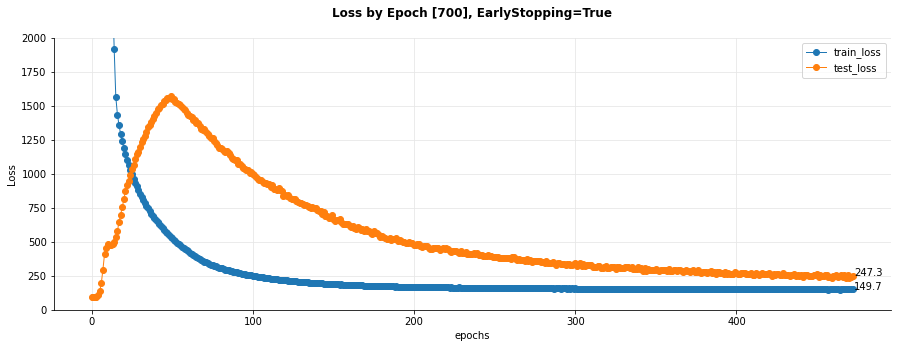

In [21]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#DenseNN-based]](#DenseNN-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue)) <br>
holdout data [[go]](#Keeping-Holdout-Samples-Aside)

# Saving Model

In [22]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_DNSe_working')

In [23]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [24]:
hold_out_X[:3]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY,Price
Date,,,,,,,,,,,
2021-05-28,38844.1,34772.4,199580.0,2.897052e+06,69.535068,1.343872,645284958.0,831.25,76650.0,215160.0,35662.5
2021-05-29,37227.1,33664.2,160430.0,2.039126e+06,47.416324,1.322726,645503002.0,806.25,-39150.0,218044.0,34584.6
2021-05-30,36388.6,33441.0,104180.0,1.082550e+06,36.614525,1.499183,645699597.0,868.75,-56250.0,196595.0,35652.8


In [25]:
hold_out_X_unrolled, hold_out_y_unrolled = nn_manager_cut.unroll_train_test_to_sequences(
    X=nn_manager_cut.scaler.transform(hold_out_X), 
    y =hold_out_y.values
)

hold_out_X_unrolled[-1:], hold_out_X_unrolled.shape[0]

>>> Method called with outer X and y. Returning X, y unrolled...


(array([[[ 3.38803545,  3.19624615,  0.02635496,  0.16940306,
          -0.07382464,  1.24351611,  1.13049455, -0.80909091,
          -1.75515024, -0.77854481,  3.34958875]]]),
 27)

In [26]:
left_off_date_index = hold_out_y.index[nn_manager_cut.training_seq_params['seq_len']:]
left_off_date_index

DatetimeIndex(['2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01',
               '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-05',
               '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
               '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21',
               '2021-06-22', '2021-06-23', '2021-06-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [27]:
left_off_pred = [nn_manager_cut.model_predict(seq.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]
                 for seq in hold_out_X_unrolled]
left_off_pred[:2]

[36721.555, 35376.81]

In [28]:
# ## one date test prediction
# nn_manager_cut.model_predict(
#     nn_manager_cut.scaler
#         .transform(hold_out_X.loc['2021-05-27'].values.reshape(1, -1))
#         .reshape(
#                 1,nn_manager_cut.training_seq_params['seq_len'],
#                 nn_manager_cut.training_seq_params['n_features'])
# )[0][0]

In [29]:
hold_out_y_df = pd.DataFrame(data=hold_out_y_unrolled, index=left_off_date_index, columns=["holdout Y"])
hold_out_pred_df = pd.DataFrame(data=left_off_pred, index=left_off_date_index, columns=["holdout Pred"])

In [30]:
hold_out_y[:6]

,Price
Date,
2021-05-28,35662.5
2021-05-29,34584.6
2021-05-30,35652.8
2021-05-31,37298.6
2021-06-01,36687.6
2021-06-02,37555.8


In [31]:
hold_out_pred_df[:5]

,holdout Pred
Date,
2021-05-29,36721.554688
2021-05-30,35376.808594
2021-05-31,35428.292969
2021-06-01,36610.851562
2021-06-02,36984.304688


<AxesSubplot:xlabel='Date'>

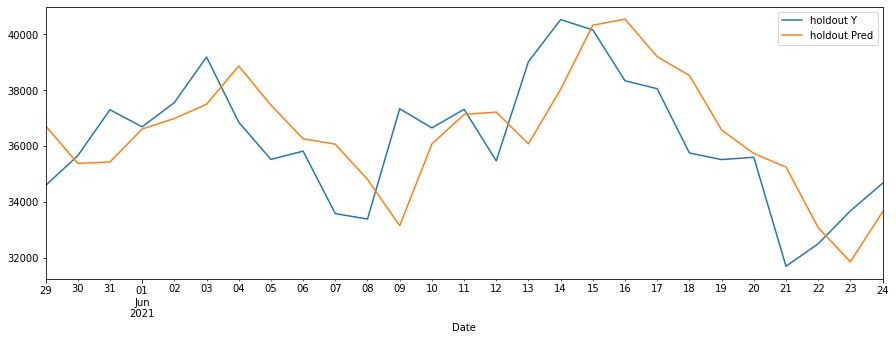

In [32]:
fig, ax = plt.subplots(1, figsize=(15,5))

hold_out_y_df.plot(ax=ax)
hold_out_pred_df.plot(ax=ax)

## think about this tomorrow
https://monosnap.com/file/bLcjLWpyUcocdmuraTyJNIWkKZLhOh

In [33]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-01'", "Date<='2014-12-01'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [34]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [35]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [36]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [37]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [38]:
# nn_manager_cut.y_test_unrolled[:3]

In [39]:
# nn_manager_cut.y_pred[:3]

In [40]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]